In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

if torch.cuda.is_available():
  print("Cuda (GPU support) is available and enabled!")
  device = torch.device("cuda")
else:
  print("Cuda (GPU support) is not available :(")
  device = torch.device("cpu")

train_data = pd.read_csv("train.csv")
train_data['DATETIME'] = pd.to_datetime(train_data['DATETIME'])

Cuda (GPU support) is not available :(


In [216]:
from sklearn.preprocessing import StandardScaler


cihaz_301 = train_data[train_data['SERVER'] == 'CIHAZ_301']
cihaz_305 = train_data[train_data['SERVER'] == 'CIHAZ_305']


#scaler = StandardScaler()
#scaler.fit(cihaz_301['CPULOAD'].values.reshape(-1,1))
#cihaz_301['CPULOAD'] = scaler.transform(cihaz_301['CPULOAD'].values.reshape(-1,1))
#
#scaler = StandardScaler()
#scaler.fit(cihaz_305['CPULOAD'].values.reshape(-1,1))
#cihaz_305['CPULOAD'] = scaler.transform(cihaz_305['CPULOAD'].values.reshape(-1,1))

unique_datetime1 = cihaz_301['DATETIME'].unique()
unique_datetime2 = cihaz_305['DATETIME'].unique()

grouped_301 = []
grouped_305 = []

#
#for date in unique_datetime1:
#  grouped_301.append((cihaz_301[cihaz_301['DATETIME'] == date])['CPULOAD'].to_numpy())
#
#for date in unique_datetime2:
#  grouped_305.append((cihaz_305[cihaz_305['DATETIME'] == date])['CPULOAD'].to_numpy())

cihaz_301 = cihaz_301.groupby('DATETIME')['CPULOAD'].mean()

cihaz_305 = cihaz_305.groupby('DATETIME')['CPULOAD'].mean()



print(cihaz_301)

DATETIME
2020-03-24 00:00:00+03:00    4.425000
2020-03-24 00:15:00+03:00    4.427500
2020-03-24 00:30:00+03:00    3.910417
2020-03-24 00:45:00+03:00    3.633750
2020-03-24 01:00:00+03:00    3.575000
                               ...   
2020-05-30 22:45:00+03:00    9.213333
2020-05-30 23:00:00+03:00    6.367083
2020-05-30 23:15:00+03:00    6.102083
2020-05-30 23:30:00+03:00    5.930833
2020-05-30 23:45:00+03:00    5.656250
Name: CPULOAD, Length: 6515, dtype: float64


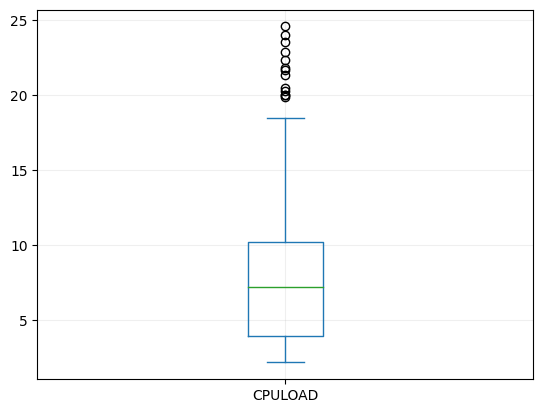

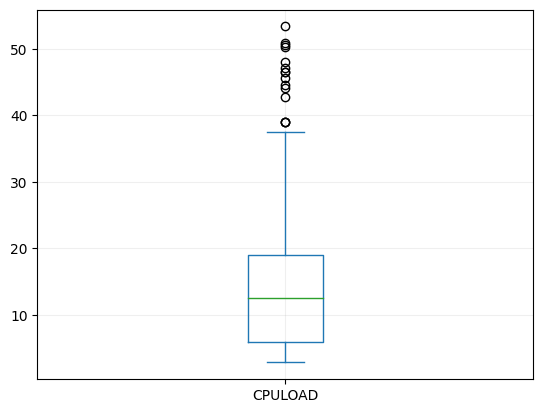

In [217]:
grouped_301 = cihaz_301
grouped_305 = cihaz_305

grouped_301.plot.box()
plt.grid(which='both', alpha=0.2)
plt.show()

grouped_305.plot.box()
plt.grid(which='both', alpha=0.2)
plt.show()

abnormal_values_dates = []

# Group values by month

# Calculate Q1, Q3 and interquartile range
q1 = grouped_301.quantile(0.25)
q3 = grouped_301.quantile(0.75)
iqr = q3 - q1

# Find anomalies
abnormal_dates = grouped_301[(grouped_301 < q1 - 1.5 * iqr) \
                      | (grouped_301 > q3 + 1.5 * iqr)].index

# Add anomalies to list
if not abnormal_dates.empty:
  abnormal_values_dates = abnormal_values_dates + list(abnormal_dates)

grouped_301.loc[abnormal_values_dates] = np.nan

# Calculate Q1, Q3 and interquartile range
q1 = grouped_305.quantile(0.25)
q3 = grouped_305.quantile(0.75)
iqr = q3 - q1

# Find anomalies
abnormal_dates = grouped_305[(grouped_305 < q1 - 1.5 * iqr) \
                      | (grouped_305 > q3 + 1.5 * iqr)].index

# Add anomalies to list
if not abnormal_dates.empty:
  abnormal_values_dates = abnormal_values_dates + list(abnormal_dates)

grouped_305.loc[abnormal_values_dates] = np.nan

grouped_301 = grouped_301.interpolate()
grouped_305 = grouped_305.interpolate()


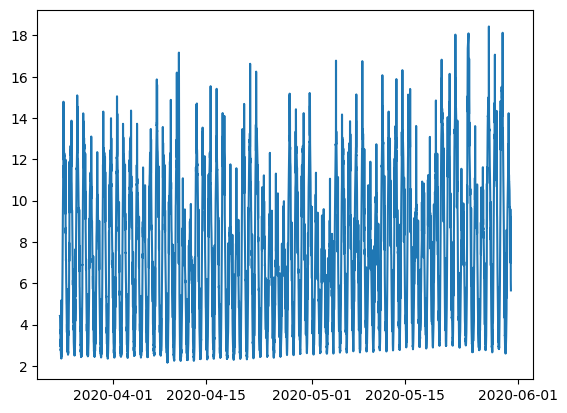

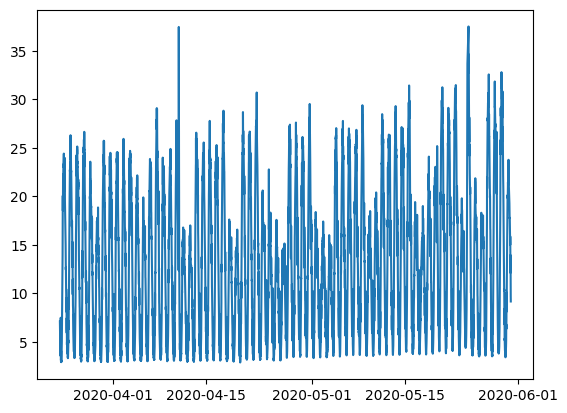

(6515,)


In [218]:
mean_301 = grouped_301
mean_305 = grouped_305


plt.plot(mean_301)
plt.show()

plt.plot(mean_305)
plt.show()

print(mean_301.shape)

In [219]:
import random
class MyWeatherPredictor(torch.nn.Module):

    def __init__(self, input_dim, hidden_dim):
        super().__init__()

        random.seed(501)
        np.random.seed(501)
        torch.manual_seed(501)

        # @TODO: Create an instance of your LSTM model and a FC layer
        # that maps the last hidden state to the output that you wish to
        # estimate
        #self.lstm = MyLSTM(input_dim,hidden_dim)
        #self.lstm2 = MyLSTM(hidden_dim,hidden_dim)

        self.lstm = torch.nn.LSTM(input_dim, hidden_dim,device=device)


        self.fc = torch.nn.Linear(hidden_dim,1,device=device)

    def forward(self, X):
        # @TODO: Forward pass through LSTM and FC layer to estimate
        # the target
        h, c = self.lstm(X)
        prediction = self.fc(h)
        return prediction

In [220]:
def train(model, criterion, optimizer, epochs, dataloader, verbose=True):
  """
    Define the trainer function. We can use this for training any model.
    The parameter names are self-explanatory.

    Returns: the loss history.
  """
  loss_history = []
  test_loss_histories = []

  for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):

      # Our batch:
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      # zero the gradients as PyTorch accumulates them
      optimizer.zero_grad()

      # Obtain the scores
      outputs = model(inputs)

      # Calculate loss
      loss = criterion(outputs.to(device), labels)

      # Backpropagate
      loss.backward()

      # Update the weights
      optimizer.step()

      loss_history.append(loss.item())

    if verbose: print(f'Epoch {epoch} / {epochs}: avg. loss of last 5 iterations {np.sum(loss_history[:-6:-1])/5}')

  return loss_history

In [221]:

#Split 1
train_set = mean_301
#Split 2
test_set = mean_301[4560:]

#Creating input-output pairs via windowing
x_train = np.lib.stride_tricks.sliding_window_view(train_set,10, axis=0)[:,:9].astype(np.float32)
y_train = np.lib.stride_tricks.sliding_window_view(train_set,10, axis=0)[:,9:].astype(np.float32)

x_test = np.lib.stride_tricks.sliding_window_view(test_set,10, axis=0)[:,:9].astype(np.float32)
y_test = np.lib.stride_tricks.sliding_window_view(test_set,10, axis=0)[:,9:].astype(np.float32)

print(mean_301[0])
print(x_train.shape)
print(y_train)


4.425
(6506, 9)
[[2.9      ]
 [2.745    ]
 [2.8220832]
 ...
 [6.102083 ]
 [5.9308333]
 [5.65625  ]]


In [222]:
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
model = MyWeatherPredictor(9,32)

batch_size = 16

epochs = 30

criterion = torch.nn.MSELoss()

train_set = TensorDataset(torch.from_numpy(x_train),torch.from_numpy(y_train))
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_set = TensorDataset(torch.from_numpy(x_test),torch.from_numpy(y_test))
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_history = train(model, criterion, optimizer, epochs, train_dataloader)

Epoch 0 / 30: avg. loss of last 5 iterations 4.270485031604767
Epoch 1 / 30: avg. loss of last 5 iterations 0.7313876450061798
Epoch 2 / 30: avg. loss of last 5 iterations 0.49151029586791994
Epoch 3 / 30: avg. loss of last 5 iterations 0.5928597629070282
Epoch 4 / 30: avg. loss of last 5 iterations 0.6059916824102402
Epoch 5 / 30: avg. loss of last 5 iterations 1.0916681945323945
Epoch 6 / 30: avg. loss of last 5 iterations 0.9008959770202637
Epoch 7 / 30: avg. loss of last 5 iterations 0.3843197077512741
Epoch 8 / 30: avg. loss of last 5 iterations 0.6246653854846954
Epoch 9 / 30: avg. loss of last 5 iterations 0.3732120096683502
Epoch 10 / 30: avg. loss of last 5 iterations 0.8096178650856019
Epoch 11 / 30: avg. loss of last 5 iterations 0.6500885784626007
Epoch 12 / 30: avg. loss of last 5 iterations 0.6770237118005753
Epoch 13 / 30: avg. loss of last 5 iterations 0.5345218479633331
Epoch 14 / 30: avg. loss of last 5 iterations 0.599642226099968
Epoch 15 / 30: avg. loss of last 5 i

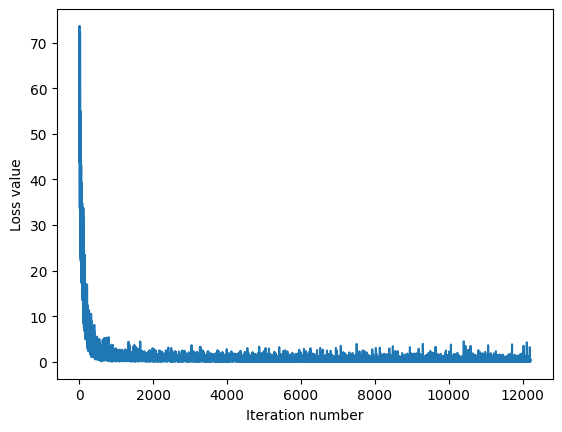

In [223]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

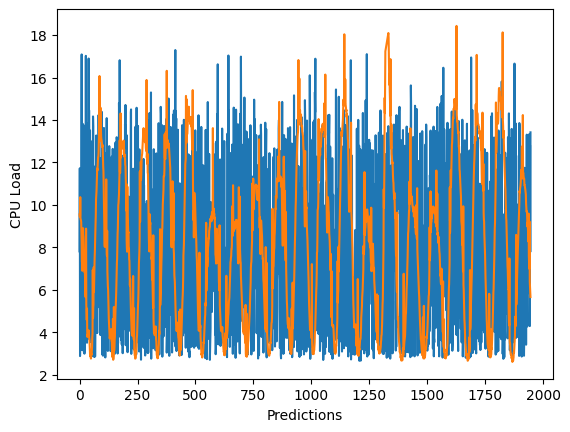

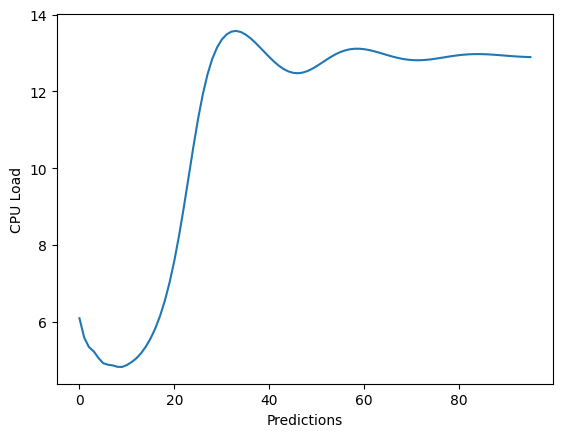

[[6.0923662185668945], [5.588677406311035], [5.339485168457031], [5.23008394241333], [5.057974815368652], [4.9204230308532715], [4.881016731262207], [4.862799167633057], [4.826329231262207], [4.823537826538086], [4.873615741729736], [4.949771404266357], [5.048770427703857], [5.182671070098877], [5.355414390563965], [5.56859827041626], [5.832691669464111], [6.158260345458984], [6.553614139556885], [7.029403209686279], [7.595973968505859], [8.254171371459961], [8.990038871765137], [9.772662162780762], [10.556288719177246], [11.289904594421387], [11.930685997009277], [12.453845024108887], [12.85560131072998], [13.148838996887207], [13.353486061096191], [13.486716270446777], [13.559124946594238], [13.577601432800293], [13.549468040466309], [13.483784675598145], [13.39023494720459], [13.277676582336426], [13.15361213684082], [13.024643898010254], [12.897196769714355], [12.777746200561523], [12.672404289245605], [12.586329460144043], [12.523388862609863], [12.486079216003418], [12.4754438400

In [224]:
out = []
with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        out += outputs.flatten().tolist()
plt.plot(out)
plt.plot(y_test.squeeze())
plt.xlabel('Predictions')
plt.ylabel('CPU Load')
plt.show()

out2 = []
with torch.no_grad():
    for i in range(96):
        if(i == 0):
            input = torch.from_numpy(np.array([x_test[-1]])).to(device)
        else:
            input = torch.FloatTensor([input[:,1:].tolist()[0] + ([out2[i-1][0]])]).to(device)
        output = model(input)

        out2 += output.tolist()

plt.plot(out2)
plt.xlabel('Predictions')
plt.ylabel('CPU Load')
plt.show()

print(out2)

In [225]:

#Split 1
train_set = mean_305
#Split 2
test_set = mean_305[4560:]

#Creating input-output pairs via windowing
x_train = np.lib.stride_tricks.sliding_window_view(train_set,10, axis=0)[:,:9].astype(np.float32)
y_train = np.lib.stride_tricks.sliding_window_view(train_set,10, axis=0)[:,9:].astype(np.float32)

x_test = np.lib.stride_tricks.sliding_window_view(test_set,10, axis=0)[:,:9].astype(np.float32)
y_test = np.lib.stride_tricks.sliding_window_view(test_set,10, axis=0)[:,9:].astype(np.float32)


In [226]:
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
model = MyWeatherPredictor(9,32)

batch_size = 16

epochs = 30

criterion = torch.nn.MSELoss()

train_set = TensorDataset(torch.from_numpy(x_train),torch.from_numpy(y_train))
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_set = TensorDataset(torch.from_numpy(x_test),torch.from_numpy(y_test))
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_history = train(model, criterion, optimizer, epochs, train_dataloader)

Epoch 0 / 30: avg. loss of last 5 iterations 34.806189346313474
Epoch 1 / 30: avg. loss of last 5 iterations 12.84080719947815
Epoch 2 / 30: avg. loss of last 5 iterations 4.438617324829101
Epoch 3 / 30: avg. loss of last 5 iterations 5.679572010040284
Epoch 4 / 30: avg. loss of last 5 iterations 2.748051846027374
Epoch 5 / 30: avg. loss of last 5 iterations 1.508680272102356
Epoch 6 / 30: avg. loss of last 5 iterations 1.9678489089012146
Epoch 7 / 30: avg. loss of last 5 iterations 2.1854376077651976
Epoch 8 / 30: avg. loss of last 5 iterations 0.9782923579216003
Epoch 9 / 30: avg. loss of last 5 iterations 1.7771321058273315
Epoch 10 / 30: avg. loss of last 5 iterations 0.8042290210723877
Epoch 11 / 30: avg. loss of last 5 iterations 1.2789695382118225
Epoch 12 / 30: avg. loss of last 5 iterations 0.7676838546991348
Epoch 13 / 30: avg. loss of last 5 iterations 1.1450544834136962
Epoch 14 / 30: avg. loss of last 5 iterations 0.79171142578125
Epoch 15 / 30: avg. loss of last 5 iterati

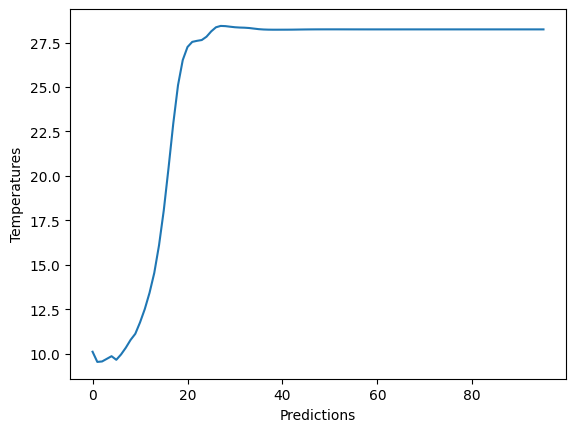

[[10.11015510559082], [9.537824630737305], [9.563915252685547], [9.71163272857666], [9.859830856323242], [9.657341003417969], [9.958276748657227], [10.335700988769531], [10.773343086242676], [11.119132995605469], [11.762100219726562], [12.510431289672852], [13.424524307250977], [14.545409202575684], [16.099506378173828], [18.061717987060547], [20.437419891357422], [22.945297241210938], [25.102994918823242], [26.519569396972656], [27.253402709960938], [27.54143524169922], [27.6004581451416], [27.645137786865234], [27.831279754638672], [28.13385581970215], [28.36322784423828], [28.439090728759766], [28.427322387695312], [28.394325256347656], [28.364479064941406], [28.347843170166016], [28.339183807373047], [28.320987701416016], [28.288604736328125], [28.257402420043945], [28.238515853881836], [28.22964859008789], [28.226421356201172], [28.226530075073242], [28.22738265991211], [28.227977752685547], [28.22983741760254], [28.23362159729004], [28.237777709960938], [28.241037368774414], [28.

In [227]:
out3 = []
with torch.no_grad():
    for i in range(96):
        if(i == 0):
            input = torch.from_numpy(np.array([x_test[-1]])).to(device)
        else:
            input = torch.FloatTensor([input[:,1:].tolist()[0] + ([out3[i-1][0]])]).to(device)
        output = model(input)

        out3 += output.tolist()

plt.plot(out3)
plt.xlabel('Predictions')
plt.ylabel('Temperatures')
plt.show()

print(out3)